Idea - start with carbon framework, evaluate by similarity to carbon skeleton, then functionalise with metric = similarity to target 

In [1]:
import rdkit
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
import rdkit.DataStructs
from rdkit.DataStructs.cDataStructs import ExplicitBitVect
from e3fp.pipeline import fprints_from_smiles, confs_from_smiles
from e3fp.conformer.util import mol_to_standardised_mol
import numpy as np

# similarity
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity, DiceSimilarity
#from e3fp.fingerprint.metrics.array_metrics import tanimoto, soergel
from e3fp.fingerprint.metrics.fprint_metrics import tanimoto, soergel

# drawing
from rdkit.Chem import Draw 
from rdkit.Chem.Draw import SimilarityMaps
import py3Dmol

In [ ]:
column_name=["Smiles"]
df1 = pd.read_csv('/home/martyn0000/fragrance_investigation/all_sat_skeletons.smi',
                sep='\r\n', engine='python', names=column_name
                )

print(df1.head(2))
print(len(df1))

df2 = pd.read_csv('/home/martyn0000/fragrance_investigation/all_unsat_skeletons.smi',
                sep='\r\n', engine='python', names=column_name
                )

print(df2.head(2))
print(len(df2))

frames = [df1, df2]
df_skeleton_smiles = pd.concat(frames)

# print(len(df_skeleton_smiles)) 5.1 million entries 

In [3]:
df_skeleton_smiles.to_csv('carbon_skeletons_smiles.csv')

In [3]:
df = pd.read_csv('/home/martyn0000/fragrance_investigation/carbon_skeletons_smiles.csv')

df_s_1 = df.iloc[:2000000, :]
print(df_s_1.head(2))
print(len(df_s_1.index))

df_s_2 = df.iloc[2000000:4000000, :]
print(df_s_2.head(2))
print(len(df_s_2.index))

df_s_3 = df.iloc[4000000:, :]
print(df_s_3.head(2))
print(len(df_s_3.index))



   Unnamed: 0 Smiles
0           0      C
1           1     CC
2000000
         Unnamed: 0                   Smiles
2000000     1680107   CC1CC2CC11CC2C=C1C1CC1
2000001     1680108  C=C1C=C2CC11CC2C=C1CC#C
2000000
         Unnamed: 0                      Smiles
4000000     3680107      CC=CC12CC3C=CC1C3CC=C2
4000001     3680108  CC=CC12CC3C(C=C1)C3(C)C=C2
1428428


In [3]:
df_skeleton_mols_1 = df_s_1.copy()
PandasTools.AddMoleculeColumnToFrame(df_skeleton_mols_1,'Smiles','molecule',includeFingerprints=True)

In [4]:
# rdkit calculate features - Morgan fingerprint 
# and store the bitvects as base64-encoded strings

# Generate Morgan fingerprints from mol object 
df_skeleton_mols_1['morgan'] = df_skeleton_mols_1['molecule'].map(lambda x: GetMorganFingerprintAsBitVect(x,2)) 
print(df_skeleton_mols_1.head(2))

# number of bits in the bitvect (need this when reading CSV back)
bit_vect_len = (df_skeleton_mols_1['morgan'].map(lambda x: x.GetNumBits()))[0]

# convert bitvects to base64-encoded string for CSV/plaintext storage
df_skeleton_mols_1['morgan64'] = df_skeleton_mols_1['morgan'].map(lambda bv: bv.ToBase64())

# throw away stuff we don't want to store (raw mol and bitvect objects)
df_s_1_for_storage = df_skeleton_mols_1.drop('molecule', axis=1).drop('morgan', axis=1)

# write to the concatenated CSV file
# `mode='w'` means "write", OVERWRITING the existing file (df8_2 through 5 will need rewriting after this)
# we DO want a header, since this is the first write / first df we write
df_s_1_for_storage.to_csv('carbon_skeletons_with_Morgan_fingerprints.csv', mode='w', index=False, header=True)
print("DONE: skeletons-1 with fingerprints written")

   Unnamed: 0 Smiles                                          molecule   
0           0      C  <rdkit.Chem.rdchem.Mol object at 0x7f8f26be0640>  \
1           1     CC  <rdkit.Chem.rdchem.Mol object at 0x7f8f26be0700>   

                                              morgan  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
DONE: skeletons-1 with fingerprints written


In [5]:
df_skeleton_mols_2 = df_s_2.copy()
PandasTools.AddMoleculeColumnToFrame(df_skeleton_mols_2,'Smiles','molecule',includeFingerprints=True)

In [6]:
# rdkit calculate features - Morgan fingerprint 
# and store the bitvects as base64-encoded strings

# Generate Morgan fingerprints from mol object 
df_skeleton_mols_2['morgan'] = df_skeleton_mols_2['molecule'].map(lambda x: GetMorganFingerprintAsBitVect(x,2)) 
print(df_skeleton_mols_2.head(2))

# convert bitvects to base64-encoded string for CSV/plaintext storage
df_skeleton_mols_2['morgan64'] = df_skeleton_mols_2['morgan'].map(lambda bv: bv.ToBase64())

# throw away stuff we don't want to store (raw mol and bitvect objects)
df_s_2_for_storage = df_skeleton_mols_2.drop('molecule', axis=1).drop('morgan', axis=1)

# write to the concatenated CSV file
# `mode='a'` means "append"
df_s_2_for_storage.to_csv('carbon_skeletons_with_Morgan_fingerprints.csv', mode='a', index=False, header=False)
print("DONE: skeletons-2 with fingerprints written")

         Unnamed: 0                   Smiles   
2000000     1680107   CC1CC2CC11CC2C=C1C1CC1  \
2000001     1680108  C=C1C=C2CC11CC2C=C1CC#C   

                                                 molecule   
2000000  <rdkit.Chem.rdchem.Mol object at 0x7f8985eff9a0>  \
2000001  <rdkit.Chem.rdchem.Mol object at 0x7f8985effb20>   

                                                    morgan  
2000000  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2000001  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
DONE: skeletons-2 with fingerprints written


In [4]:
df_skeleton_mols_3 = df_s_3.copy()
PandasTools.AddMoleculeColumnToFrame(df_skeleton_mols_3,'Smiles','molecule',includeFingerprints=True)

In [5]:
# rdkit calculate features - Morgan fingerprint 
# and store the bitvects as base64-encoded strings

# Generate Morgan fingerprints from mol object 
df_skeleton_mols_3['morgan'] = df_skeleton_mols_3['molecule'].map(lambda x: GetMorganFingerprintAsBitVect(x,2)) 
print(df_skeleton_mols_3.head(2))

# convert bitvects to base64-encoded string for CSV/plaintext storage
df_skeleton_mols_3['morgan64'] = df_skeleton_mols_3['morgan'].map(lambda bv: bv.ToBase64())

# throw away stuff we don't want to store (raw mol and bitvect objects)
df_s_3_for_storage = df_skeleton_mols_3.drop('molecule', axis=1).drop('morgan', axis=1)

# write to the concatenated CSV file
df_s_3_for_storage.to_csv('carbon_skeletons_with_Morgan_fingerprints.csv', mode='a', index=False, header=False)
print("DONE: skeletons-3 with fingerprints written")

         Unnamed: 0                      Smiles   
4000000     3680107      CC=CC12CC3C=CC1C3CC=C2  \
4000001     3680108  CC=CC12CC3C(C=C1)C3(C)C=C2   

                                                 molecule   
4000000  <rdkit.Chem.rdchem.Mol object at 0x7fde5de76aa0>  \
4000001  <rdkit.Chem.rdchem.Mol object at 0x7fde5de76b60>   

                                                    morgan  
4000000  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4000001  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
DONE: skeletons-3 with fingerprints written


In [43]:
# convert the given base64-encoded string form of a bitvect back into a bitvect
def bit_vect_from_string(base64_string: str):
    # create an empty bitvect
    emptyBitVect = ExplicitBitVect(int(bit_vect_len))
    # update the bitvect to the value in the base64-encoded string
    emptyBitVect.FromBase64(base64_string)
    # return the updated bitvect (which now contains the right value!)
    return emptyBitVect

In [44]:
# intial morgan fingerprint comparison of carbon framework 
df_skeletons_Morgan = pd.read_csv('/home/martyn0000/fragrance_investigation/carbon_skeletons_with_Morgan_fingerprints.csv')
bit_vect_len = 2048
df_skeletons_Morgan['morgan'] = df_skeletons_Morgan['morgan64'].map(lambda s: bit_vect_from_string(s))

# specify target molecule as SMILES 
similarity_target=Chem.MolFromSmiles("C[C@]1(CC=C2CCCC(C)([C@@]2([C@H]1C)C)C)C(C)=C") 

def get_dataframe_with_x_most_similar_compounds_to_query(query, mol_df, molCol='molecule', x=int):
    query_fp = GetMorganFingerprintAsBitVect(query,2)
    mol_df['similarity_1_Morgan'] = mol_df['morgan'].map(lambda x: TanimotoSimilarity(query_fp, x))
    mol_df.sort_values(['similarity_1_Morgan'], ascending=False, inplace=True)
    return mol_df[:x].copy()  

similarity_df = get_dataframe_with_x_most_similar_compounds_to_query(similarity_target, df_skeletons_Morgan, x=100000)
similarity_df.head(10)

,Unnamed: 0,Smiles,morgan64,morgan,similarity_1_Morgan
4022948,3703055,CC(=C)C12CCCC1=CCC2(C)C,4P///wAIAAAcAAAAeo0BEEUAdhLERHkAcHpAcggKOASeCC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.512195
2527684,2207791,CC1CC=C2CCCC(C)(C)C12C,4P///wAIAAAaAAAAdQE8dQBCdrr4KQG4EDgEQFwIIN5EbB...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.500000
4315868,3995975,CC(=C)C1(C)CC=C2CCCC12C,4P///wAIAAAcAAAAeo0BAQAydj0AeQDsaEoICjgElAgq3r...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.476190
4017063,3697170,CC(=C)C12CC3CCC(=CC1)C23C,4P///wAIAAAfAAAAAmoEBPCKSCUAmC7uPFam7LQCBEQEUQ...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.444444
4017064,3697171,CC(=C)C12CC3CC=C(CC1)C23C,4P///wAIAAAfAAAAbpUAPO0BLopiPFamgmi0AgREBMqkDC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.444444
2931500,2611607,CC1C(C)(C)C=CCC1(C)C(C)=C,4P///wAIAAAZAAAARCgIAPkApQA8CvEAKQAmSKK0AgREBI...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.439024
399136,79243,CC1C(C)=CCC1(C)C(C)=C,4P///wAIAAAZAAAAUhoK2nEFeQDstAIERAQUWNhgRHAaTv...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.439024
2938315,2618422,CC1CCC(C)=CCC1(C)C(C)=C,4P///wAIAAAdAAAAbgopB3jCNkhqtAIERAT0UmBEHlAaVQ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.431818
1796667,1476774,CC1C2(C)CC=C3CCCC13C=C2,4P///wAIAAAdAAAAelzRAOZMdhjGpQAm7IA2EDgEniqmGB...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.431818
1836533,1516640,CC1C2(C)C(=C)CC=C3CCCC123,4P///wAIAAAdAAAARuUAHjkBdlytACkBuAwCOAQagireGi...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.431818


In [13]:
# write to .csv 
similarity_df_for_csv = similarity_df.drop(['morgan64'], axis=1).drop(['morgan'], axis=1)
similarity_df_for_csv.to_csv('skeletons_similarity_top_100000.csv')

In [3]:
# 3D structure 
df_skeletons_filtered = pd.read_csv('/home/martyn0000/fragrance_investigation/skeletons_similarity_top_100000.csv')

df_filtered = df_skeletons_filtered.head(200)
# get SMILES from similarity_df, create fingerprint column, generate fingerprints and put in dataframe 
df_filtered['fingerprints'] = df_filtered.apply(lambda x: fprints_from_smiles(x.Smiles, str(x.name)), axis=1)

nrows_pre_explosion = df_filtered.shape[0]
# `fprints_from_smiles` returns a list of fingerprints
# `explode` expands the list into a separate entry for each fingerprint
df_filtered = df_filtered.explode('fingerprints')

nrows_post_explosion = df_filtered.shape[0]
print(f"Calling `explode` created {nrows_post_explosion / nrows_pre_explosion}-times more entries!")

# print the first 2 entries, adjusted for explosion
print(df_filtered.head(2 * int(nrows_post_explosion/nrows_pre_explosion)))

2023-05-26 15:16:29,329|INFO|Generating conformers for 0.
2023-05-26 15:16:30,435|INFO|Generated 4 conformers for 0.
2023-05-26 15:16:30,436|INFO|Generating fingerprints for 0.
2023-05-26 15:16:30,554|INFO|Generated 3 fingerprints for 0.
2023-05-26 15:16:30,556|INFO|Generating conformers for 1.
2023-05-26 15:16:31,650|INFO|Generated 7 conformers for 1.
2023-05-26 15:16:31,651|INFO|Generating fingerprints for 1.
2023-05-26 15:16:31,736|INFO|Generated 3 fingerprints for 1.
2023-05-26 15:16:31,737|INFO|Generating conformers for 2.
2023-05-26 15:16:32,759|INFO|Generated 10 conformers for 2.
2023-05-26 15:16:32,760|INFO|Generating fingerprints for 2.
2023-05-26 15:16:32,907|INFO|Generated 3 fingerprints for 2.
2023-05-26 15:16:32,908|INFO|Generating conformers for 3.
2023-05-26 15:16:33,934|INFO|Generated 8 conformers for 3.
2023-05-26 15:16:33,935|INFO|Generating fingerprints for 3.
2023-05-26 15:16:34,035|INFO|Generated 3 fingerprints for 3.
2023-05-26 15:16:34,036|INFO|Generating conform

Calling `explode` created 2.975-times more entries!
   Unnamed: 0.1  Unnamed: 0                   Smiles  similarity_1_Morgan   
0       4022948     3703055  CC(=C)C12CCCC1=CCC2(C)C             0.512195  \
0       4022948     3703055  CC(=C)C12CCCC1=CCC2(C)C             0.512195   
0       4022948     3703055  CC(=C)C12CCCC1=CCC2(C)C             0.512195   
1       2527684     2207791   CC1CC=C2CCCC(C)(C)C12C             0.500000   

                                        fingerprints  
0  (False, False, False, False, False, False, Fal...  
0  (False, False, False, False, False, False, Fal...  
0  (False, False, False, False, False, False, Fal...  
1  (False, False, False, False, False, False, Fal...  


/tmp/ipykernel_2189/1059702517.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['fingerprints'] = df_filtered.apply(lambda x: fprints_from_smiles(x.Smiles, str(x.name)), axis=1)


2023-05-26 15:21:24,579|INFO|Generating conformers for query.
2023-05-26 15:21:29,445|INFO|Generated 10 conformers for query.
2023-05-26 15:21:29,446|INFO|Generating fingerprints for query.
2023-05-26 15:21:29,566|INFO|Generated 3 fingerprints for query.


We are about to call `explode`.
This will create 3-times more entries!
0    0.377778
0    0.377778
0    0.361702
0    0.377778
0    0.377778
0    0.361702
0    0.377778
0    0.377778
0    0.361702
Name: 3D_similarity, dtype: object


,Unnamed: 0.1,Unnamed: 0,Smiles,similarity_1_Morgan,fingerprints,3D_similarity,molecule
5,2931500,2611607,CC1C(C)(C)C=CCC1(C)C(C)=C,0.439024,"(False, False, False, False, False, False, Fal...",0.404762,
59,2932931,2613038,CC1CC=C(C)CCC1(C)C(C)=C,0.400000,"(False, False, False, False, False, False, Fal...",0.4,
7,2938315,2618422,CC1CCC(C)=CCC1(C)C(C)=C,0.431818,"(False, False, False, False, False, False, Fal...",0.4,
11,2928346,2608453,CC1C=C(C)CCCC1(C)C(C)=C,0.431818,"(False, False, False, False, False, False, Fal...",0.4,
68,2494290,2174397,CC1CC=C2CCC(C)(C12)C(C)=C,0.391304,"(False, False, False, False, False, False, Fal...",0.391304,
18,771462,451569,CC1CC(C)=CCC1(C)C(C)=C,0.428571,"(False, False, False, False, False, False, Fal...",0.386364,
89,2930661,2610768,CC1C(=C)CCCCC1(C)C(C)=C,0.386364,"(False, False, False, False, False, False, Fal...",0.386364,
0,4022948,3703055,CC(=C)C12CCCC1=CCC2(C)C,0.512195,"(False, False, False, False, False, False, Fal...",0.377778,
24,2931764,2611871,CC1C(C)C(C)(CC=C1C)C(C)=C,0.418605,"(False, False, False, False, False, False, Fal...",0.377778,
0,4022948,3703055,CC(=C)C12CCCC1=CCC2(C)C,0.512195,"(False, False, False, False, False, False, Fal...",0.377778,

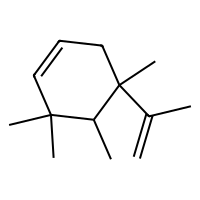
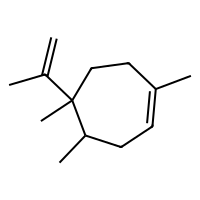
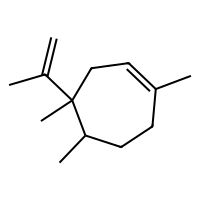
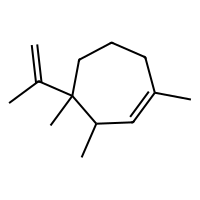
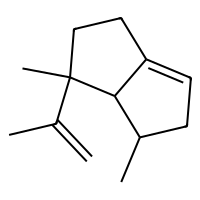
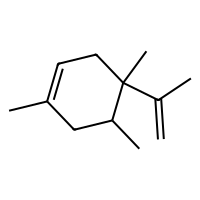
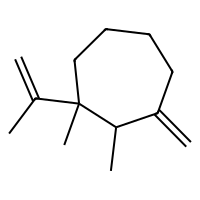
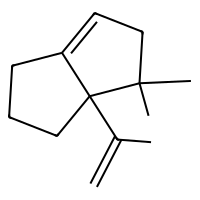
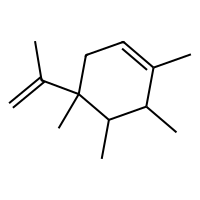
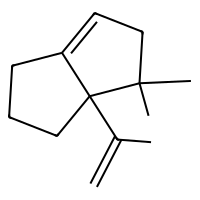
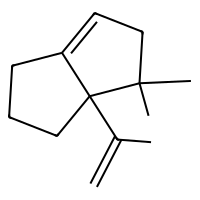
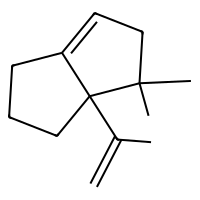
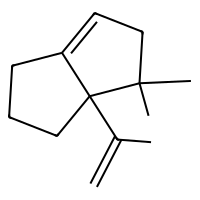
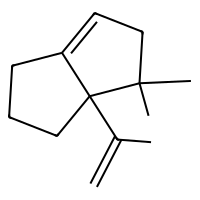
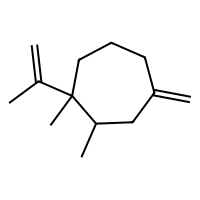
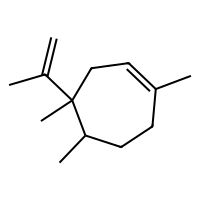
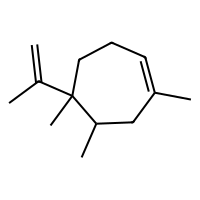
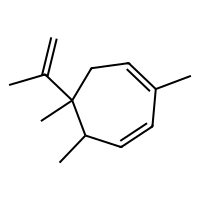
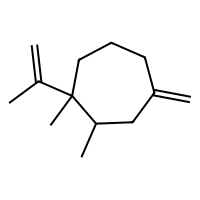
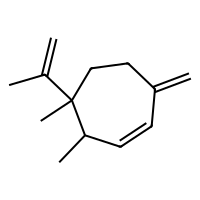

In [4]:
similarity_target="C[C@]1(CC=C2CCCC(C)([C@@]2([C@H]1C)C)C)C(C)=C"

def get_dataframe_with_x_most_similar_3D_compounds_to_query(query, mol_df, x=int):
    query_3D_fp_list = fprints_from_smiles(query, "query")
    # CAUTION: the line below removes the default limit of only generating the first 3 fingerprints
    #query_3D_fp_list = fprints_from_smiles(query, "query", fprint_params={"first": -1})
    
    mol_df['3D_similarity'] = mol_df['fingerprints'].map(
        # as with the dataframe, the query contains multiple fingerprints so we compare with each...
        lambda fp: [tanimoto(query_fp, fp) for query_fp in query_3D_fp_list]
        )
    # ... and then we `explode` the lists into individual entries
    print("We are about to call `explode`.")
    print(f"This will create {len(query_3D_fp_list)}-times more entries!")
    mol_df = mol_df.explode('3D_similarity')

    # sanity-check that we actually have some values
    print(mol_df['3D_similarity'].head(9))

    mol_df.sort_values(['3D_similarity'], ascending=False, inplace=True)
    return mol_df[:x].copy()

similarity_3D_df = get_dataframe_with_x_most_similar_3D_compounds_to_query(similarity_target, df_filtered, x=200)
PandasTools.AddMoleculeColumnToFrame(similarity_3D_df,'Smiles','molecule',includeFingerprints=True)
PandasTools.RenderImagesInAllDataFrames()
similarity_3D_df.head(20)

,molecule
0,
1,
2,
3,
4,
5,
6,
7,
8,
9,

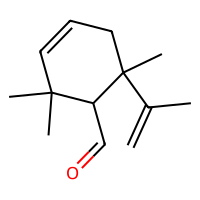
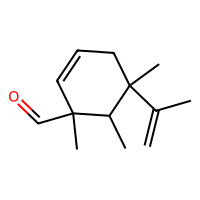
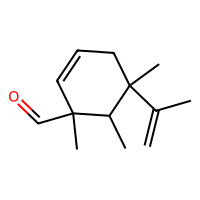
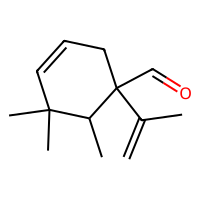
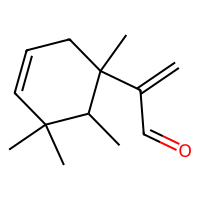
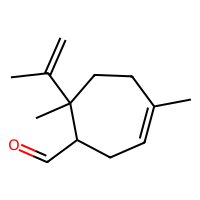
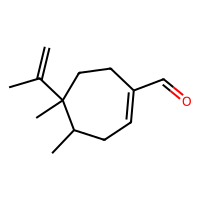
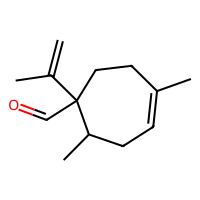
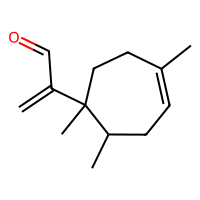
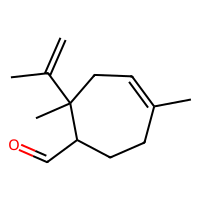
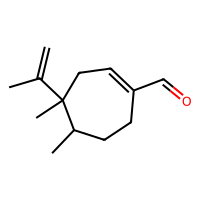
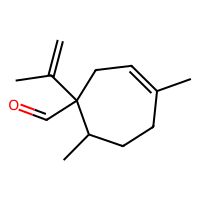
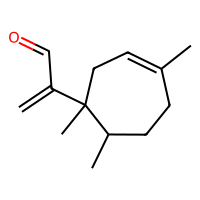
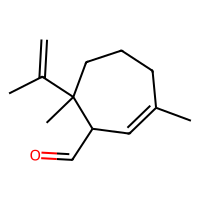
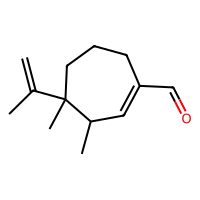
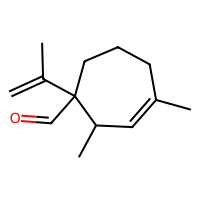
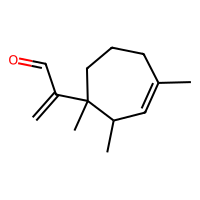
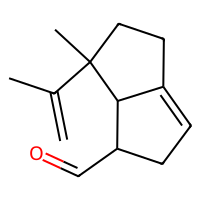
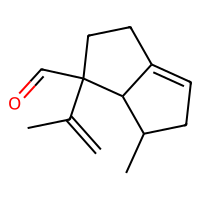
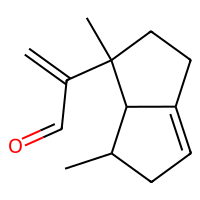
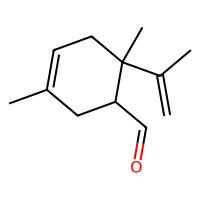
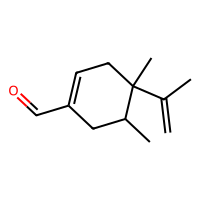
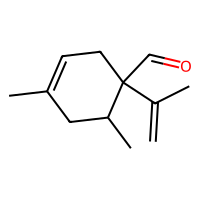
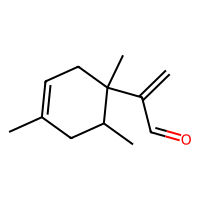
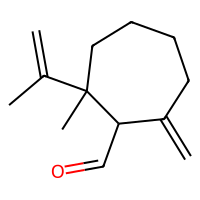
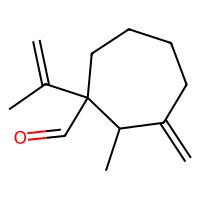
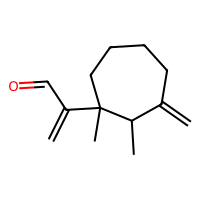
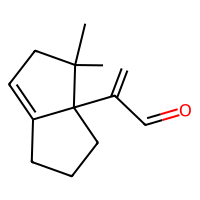
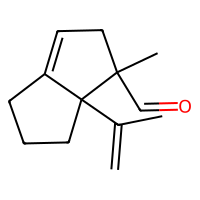
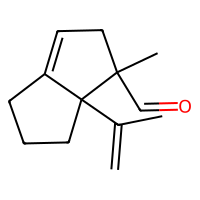

In [21]:
# function to mutate entries in dataframe, C=C to C=O 

#test_df = df_skeleton_mols_3.head(5)

# some unwanted behaviour - causing disconnection 

def add_carbonyl_to_dataframe_mols(dataframe):
    output_tuple = ()
    # just need the molecule column, get rid of everything else 
    df = dataframe['molecule'].to_frame()
    # generate tuple of new molecules for each entry, sum to one tuple 
    for x in df['molecule']:
        tuple_x = Chem.ReplaceSubstructs(x, Chem.MolFromSmarts('[CH3]'), Chem.MolFromSmiles('C=O'), useChirality=True)
        output_tuple += tuple_x
    # convert to output dataframe 
    return pd.DataFrame(output_tuple, columns=['molecule'])

#test_output = add_carbonyl_to_dataframe_mols(test_df)
PandasTools.RenderImagesInAllDataFrames()
#test_output.head()

skeletons_CO = add_carbonyl_to_dataframe_mols(similarity_3D_df)
skeletons_CO.head(30)

,molecule
0,
1,
2,
3,
4,

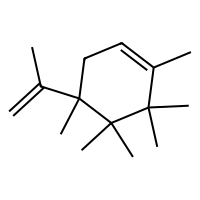
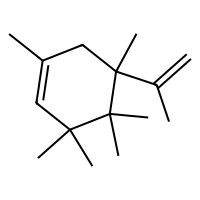
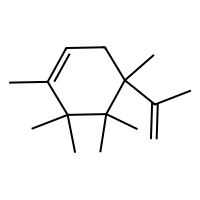
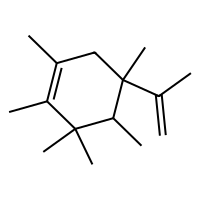
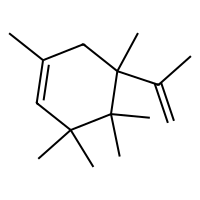

In [6]:
# function to mutate entries in dataframe, methylation i.e. add -CH3 to CH, CH2, CH3

# monomethylation 
# because this just requires an input dataframe with a 'molecule' column and generates an output dataframe with a 'molecule' column, it can be applied multiple times for multiple rounds of methylation.
# approximately increases the size of the database tenfold each time it is applied 
def add_1x_CH3_to_dataframe_mols(dataframe):
    output_tuple = ()
    df = dataframe['molecule'].to_frame()
    for x in df['molecule']:
        CH_tuple = Chem.ReplaceSubstructs(x, Chem.MolFromSmarts('[CH]'), Chem.MolFromSmiles('CC'), useChirality=True)
        output_tuple += CH_tuple
    for x in df['molecule']:
        CH2_tuple = Chem.ReplaceSubstructs(x, Chem.MolFromSmarts('[CH2]'), Chem.MolFromSmiles('CC'), useChirality=True)
        output_tuple += CH2_tuple
    for x in df['molecule']:
        CH3_tuple = Chem.ReplaceSubstructs(x, Chem.MolFromSmarts('[CH3]'), Chem.MolFromSmiles('CC'), useChirality=True)
        output_tuple += CH3_tuple
    return pd.DataFrame(output_tuple, columns=['molecule'])


#test_df = similarity_3D_df.head(5)
#test_output = add_1x_CH3_to_dataframe_mols(test_df)
#test_output_ii = add_1x_CH3_to_dataframe_mols(test_output)
PandasTools.RenderImagesInAllDataFrames()
#print(len(test_output_ii))
#test_output_ii.head()

skeletons_CH3_1 = add_1x_CH3_to_dataframe_mols(similarity_3D_df)
skeletons_CH3_2 = add_1x_CH3_to_dataframe_mols(skeletons_CH3_1)

skeletons_CH3_1.head()
skeletons_CH3_2.head()


In [7]:
def add_1x_OH_to_dataframe_mols(dataframe):
    output_tuple = ()
    df = dataframe['molecule'].to_frame()
    for x in df['molecule']:
        CH_tuple = Chem.ReplaceSubstructs(x, Chem.MolFromSmarts('[CH]'), Chem.MolFromSmiles('CO'), useChirality=True)
        output_tuple += CH_tuple
    for x in df['molecule']:
        CH2_tuple = Chem.ReplaceSubstructs(x, Chem.MolFromSmarts('[CH2]'), Chem.MolFromSmiles('CO'), useChirality=True)
        output_tuple += CH2_tuple
    for x in df['molecule']:
        CH3_tuple = Chem.ReplaceSubstructs(x, Chem.MolFromSmarts('[CH3]'), Chem.MolFromSmiles('CO'), useChirality=True)
        output_tuple += CH3_tuple
    return pd.DataFrame(output_tuple, columns=['molecule'])

#test_df = similarity_3D_df.head(5)
#test_output = add_1x_OH_to_dataframe_mols(test_df)
#test_output_ii = add_1x_OH_to_dataframe_mols(test_output)
PandasTools.RenderImagesInAllDataFrames()
#print(len(test_output_ii))
#test_output_ii.head()

skeletons_OH = add_1x_OH_to_dataframe_mols(similarity_3D_df)
skeletons_OH_CH3 = add_1x_CH3_to_dataframe_mols(skeletons_OH)
skeletons_OH_CH3_2 = add_1x_CH3_to_dataframe_mols(skeletons_OH_CH3)

In [22]:
# combine skeletons+C=O, skeletons+CH3 (1, 2), skeletons+C=O+Me

skeletons_CO_CH3 = add_1x_CH3_to_dataframe_mols(skeletons_CO)

skeletons_CO_CH3_2 = add_1x_CH3_to_dataframe_mols(skeletons_CO_CH3)

skeletons_CO_OH = add_1x_OH_to_dataframe_mols(skeletons_CO)

skeletons_CO_OH_CH3 = add_1x_CH3_to_dataframe_mols(skeletons_CO_OH)

#skeletons_CO_OH_CH3_2 = add_1x_CH3_to_dataframe_mols(skeletons_CO_OH_CH3)

In [40]:
frames = [skeletons_CO, 
          skeletons_CO_CH3, 
          #skeletons_CO_CH3_2, 
          skeletons_OH, 
          #skeletons_OH_CH3, 
          #skeletons_OH_CH3_2, 
          skeletons_CO_OH, 
          #skeletons_CO_OH_CH3
          ]

# commented out the functions causing chemical infeasibility problems 

functionalised_skeletons = pd.concat(frames)

print(len(functionalised_skeletons))

12705


In [42]:
# Morgan

# need to find a way to sanitise dataframe by removing molecules that were disconnected 

functionalised_skeletons['molecule_sanitised'] = functionalised_skeletons['molecule'].map(lambda x: Chem.SanitizeMol(x))

# Generate Morgan fingerprints from mol object 
functionalised_skeletons['morgan'] = functionalised_skeletons['molecule'].map(lambda x: GetMorganFingerprintAsBitVect(x,2)) 
print(functionalised_skeletons.head(2))

# generate SMILES from mol object
functionalised_skeletons['Smiles'] = functionalised_skeletons['molecule'].map(lambda x: Chem.MolToSmiles(x))

# convert bitvects to base64-encoded string for CSV/plaintext storage
functionalised_skeletons['morgan64'] = functionalised_skeletons['morgan'].map(lambda bv: bv.ToBase64())

# throw away stuff we don't want to store (raw mol and bitvect objects)
functionalised_skeletons_for_storage = functionalised_skeletons.drop('molecule', axis=1).drop('morgan', axis=1)
print(functionalised_skeletons_for_storage.head(2))

functionalised_skeletons_for_storage.to_csv('functionalised_skeletons_with_Morgan_fingerprints.csv', index=False)
print("DONE: functionalised skeletons with Morgan fingerprints written")

                                           molecule  molecule_sanitised   
0  <rdkit.Chem.rdchem.Mol object at 0x7f3df20743c0>                   0  \
1  <rdkit.Chem.rdchem.Mol object at 0x7f3df20746d0>                   0   

                                              morgan  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
   molecule_sanitised                       Smiles   
0                   0  C=C(C)C1(C)CC=CC(C)(C)C1C=O  \
1                   0  C=C(C)C1(C)CC=CC(C)(C=O)C1C   

                                            morgan64  
0  4P///wAIAAAdAAAARCgKXQBBAUjxAAJWuCZIohKGGAIERA...  
1  4P///wAIAAAeAAAARCgIAHb1A26wAla4JkiimhgCBEQEhs...  
DONE: functionalised skeletons with Morgan fingerprints written


In [45]:

functionalised_skeletons_Morgan = pd.read_csv('/home/martyn0000/fragrance_investigation/functionalised_skeletons_with_Morgan_fingerprints.csv')
bit_vect_len = 2048
functionalised_skeletons_Morgan['morgan'] = functionalised_skeletons_Morgan['morgan64'].map(lambda s: bit_vect_from_string(s))

# specify target molecule as SMILES 
similarity_target=Chem.MolFromSmiles("C[C@]1(CC=C2CCCC(C)([C@@]2([C@H]1C)C)C)C(C)=C") 

def get_dataframe_with_x_most_similar_compounds_to_query_2(query, mol_df, molCol='molecule', x=int):
    query_fp = GetMorganFingerprintAsBitVect(query,2)
    mol_df['similarity_2_Morgan'] = mol_df['morgan'].map(lambda x: TanimotoSimilarity(query_fp, x))
    mol_df.sort_values(['similarity_2_Morgan'], ascending=False, inplace=True)
    return mol_df[:x].copy()  

similarity_df = get_dataframe_with_x_most_similar_compounds_to_query_2(similarity_target, functionalised_skeletons_Morgan, x=1000)
similarity_df.head(10)

,molecule_sanitised,Smiles,morgan64,morgan,similarity_2_Morgan
5848,0,C=C(C)C1(C)CC=C(O)C(C)(C)C1C,4P///wAIAAAbAAAAbggA/HkApGUBAHUA7LQCBEQEtpBgRF...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.487805
5661,0,C=C(C)C1(C)CC=C(O)C(C)(C)C1C,4P///wAIAAAbAAAAbggA/HkApGUBAHUA7LQCBEQEtpBgRF...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.487805
6029,0,C=C(C)C1(O)CC=C2CCCC2(C)C1,4P///wAIAAAfAAAAevkASGkAIjoWeqJ5AOy0CAowBgSeGg...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.477273
6025,0,C=C(C)C1(O)CC=C2CCCC2(C)C1,4P///wAIAAAfAAAAevkASGkAIjoWeqJ5AOy0CAowBgSeGg...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.477273
6027,0,C=C(C)C1(O)CC=C2CCCC2(C)C1,4P///wAIAAAfAAAAevkASGkAIjoWeqJ5AOy0CAowBgSeGg...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.477273
5982,0,C=C(C)C1(C)CC=C(C)C(C)(O)C1C,4P///wAIAAAcAAAAbggAjQSsngEAOsYktAIERAS6jGBEVh...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.476190
5769,0,C=C(C)C1(C)CC=C(C)C(C)(O)C1C,4P///wAIAAAcAAAAbggAjQSsngEAOsYktAIERAS6jGBEVh...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.476190
5676,0,C=C(C)C1(C)CC=C(C)C(C)(O)C1C,4P///wAIAAAcAAAAbggAjQSsngEAOsYktAIERAS6jGBEVh...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.476190
5737,0,C=C(C)C1(C)CC=C2CCCC21O,4P///wAIAAAdAAAAehRhAWkAdj0AYNrstAgKDCoElAgaDt...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.465116
5780,0,C=C(C)C12CCCC1=CCC2(C)O,4P///wAIAAAdAAAAeo0BEEUAdthEeQBwerQICjgEnhoOnE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.465116
